In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter, sobel
from skimage.metrics import structural_similarity as ssim
import cv2 as cv
%matplotlib inline

from src.utils import *
from src.fusion import *
from src.metrics import (structural_similarity_metric, 
                        structural_similarity_metric_colored, 
                        normalized_mutual_information_metric, 
                        edge_information_metric)

In [5]:
%load_ext autoreload
%autoreload 2

# Import images

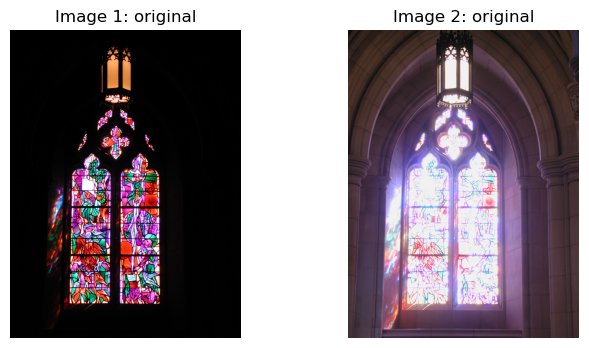

In [6]:
im1 = plt.imread("dataset/cathedral1.jpg")
im2 = plt.imread("dataset/cathedral2.jpg")
show_images(im1, im2, 'original', 'original')

# Image fusion with guided filtering

## Two-scale image decomposition

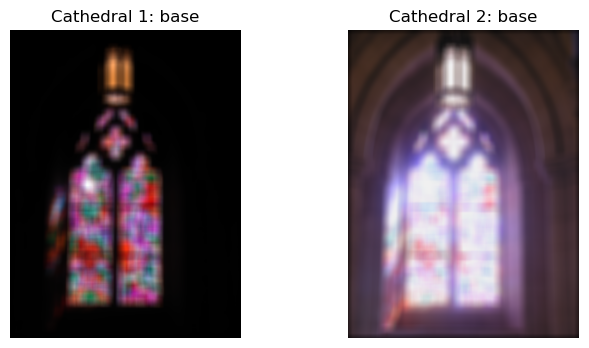

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


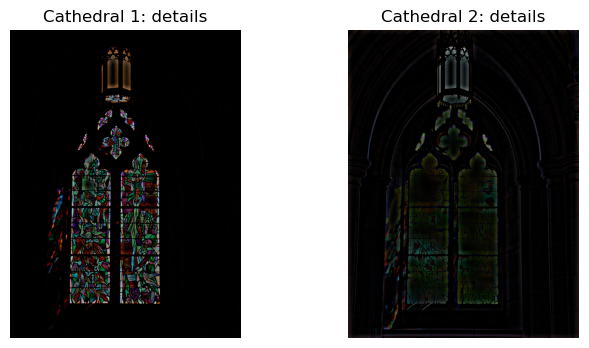

In [4]:
# Parameters
average_filter_size = 31

base1, detail1 = get_base_detail_layers(im1, average_filter_size)
base2, detail2 = get_base_detail_layers(im2, average_filter_size)

# Plot results
show_images(base1, base2, 'base', 'base')
show_images(detail1, detail2, 'details', 'details')

## Weight Map Construction With Guided Filtering

## Get saliency maps

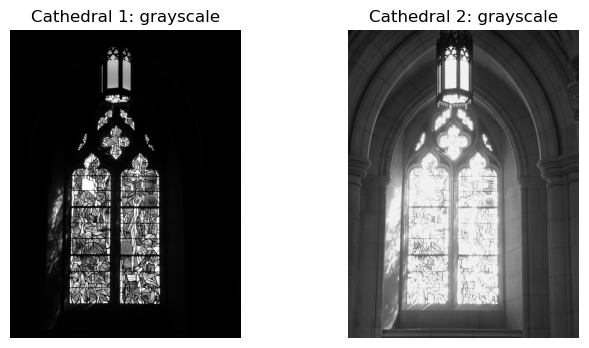

In [5]:
# We will convert images to grayscale to apply Laplacian filter
show_images(rgb2gray(im1), rgb2gray(im2), 'grayscale', 'grayscale', gray=True)

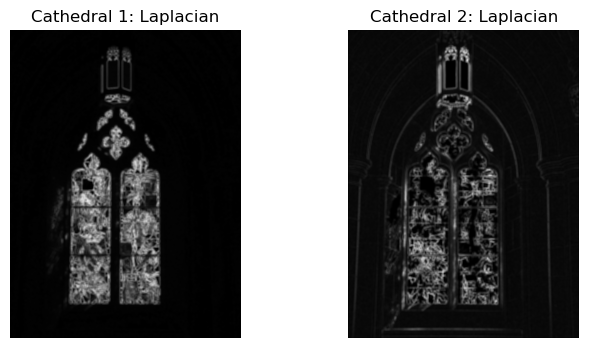

In [6]:
# Inspection of the Laplacian filter
H1 = apply_laplacian_filter(im1, kernel_size=3, local_average_size=7)
H2 = apply_laplacian_filter(im2, kernel_size=3, local_average_size=7)

# Show images
show_images(H1, H2, 'Laplacian', 'Laplacian', gray=True)

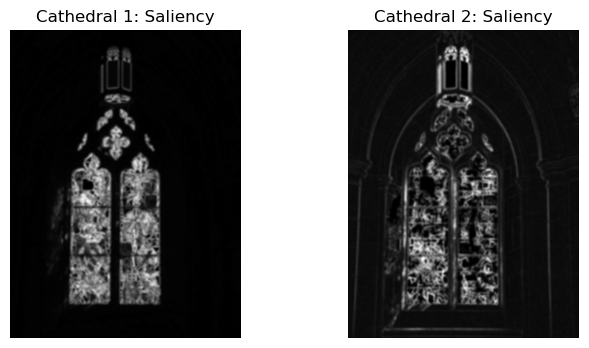

In [7]:
# Parameters
sigma = 5 # Standard deviation of the Gaussian kernel
radius = 5 # Radius of the Gaussian filter

# Compute saliency maps
saliency1 = get_saliency_map(im1, laplacian_kernel_size=3, local_average_size=7, gaussian_filter_sigma=sigma, gaussian_filter_radius=radius)
saliency2 = get_saliency_map(im2, laplacian_kernel_size=3, local_average_size=7, gaussian_filter_sigma=sigma, gaussian_filter_radius=radius)
saliency_maps = np.array([saliency1, saliency2])
show_images(saliency1, saliency2, 'Saliency', 'Saliency', gray=True)

### Get weight masks by saliency comparison

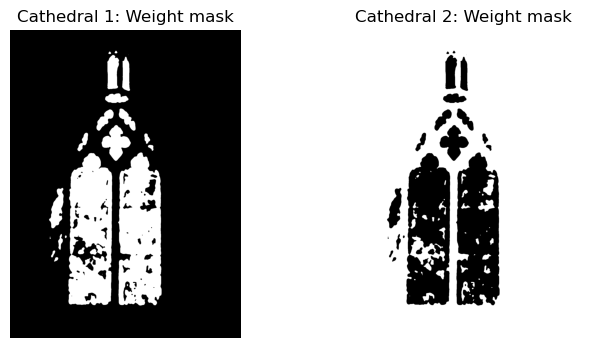

In [8]:
# Here implemented for only 2 images
P1, P2 = get_weight_mask_precursors(saliency_maps)
show_images(P1, P2, 'Weight mask', 'Weight mask', gray=True)

### Guided Filtering on weight masks to obtain spatial consistency

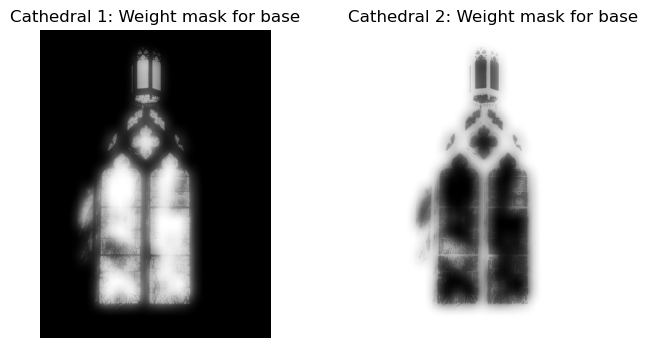

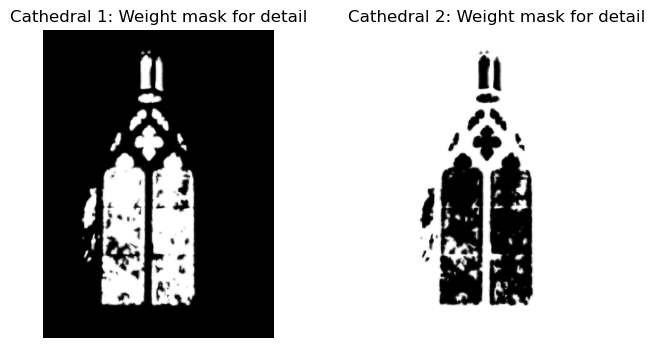

In [9]:
r1 = 45
r2 = 7
eps1 = 0.3
eps2 = 1e-6
W1B, W2B, W1D, W2D = get_weight_masks(saliency_maps, im1, im2, r1, eps1, r2, eps2)
show_images(W1B, W2B, 'Weight mask for base', 'Weight mask for base', gray=True)
show_images(W1D, W2D, 'Weight mask for detail', 'Weight mask for detail', gray=True)

### Reconstruction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


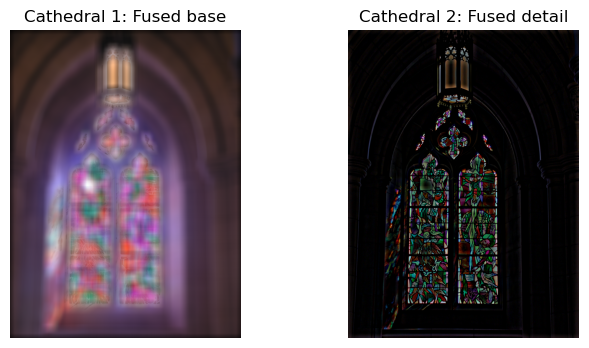

In [10]:
fusedB, fusedD = fuse_layers(base1, base2, detail1, detail2, W1B, W2B, W1D, W2D)
show_images(fusedB, fusedD, 'Fused base', 'Fused detail')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


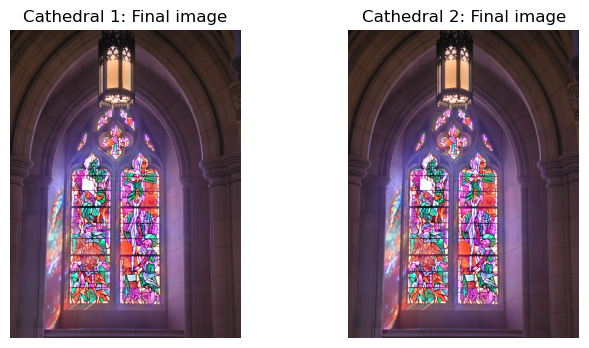

In [11]:
final_img = fusedB + fusedD
show_images(final_img, final_img, 'Final image', 'Final image')

# Test full pipeline

In [7]:
fused_image = fuse_images(im1, im2, verbose=False)

(2048, 1536)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1535.5, 2047.5, -0.5)

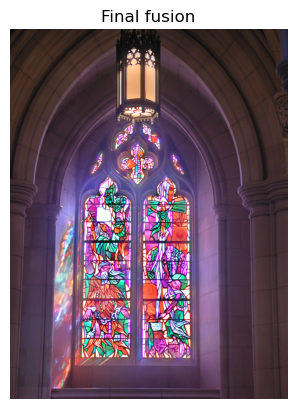

In [13]:
plt.imshow(fused_image)
plt.title("Final fusion")
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 199.5, 199.5, -0.5)

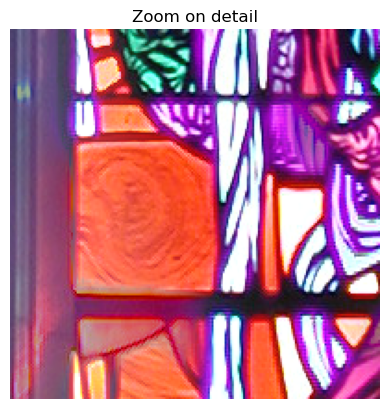

In [14]:
#Zooming on details
top_left = [1350,700]
plt.imshow(fused_image[top_left[0]:top_left[0]+200, top_left[1]:top_left[1]+200, :])
plt.title("Zoom on detail")
plt.axis('off')

# Testing on other multi-focus images

In [140]:
golf1 = plt.imread("dataset/multi-focus/grayscale/g_09_1.tif")
golf2 = plt.imread("dataset/multi-focus/grayscale/g_09_2.tif")
fused_golf = fuse_images([golf1, golf2])
print(fused_golf.shape)

(234, 322)


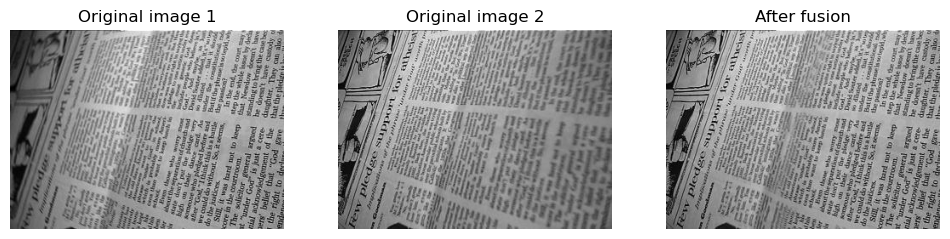

In [141]:
show_3_images(golf1, golf2, fused_golf, "Original image 1", "Original image 2", "After fusion", gray=True)

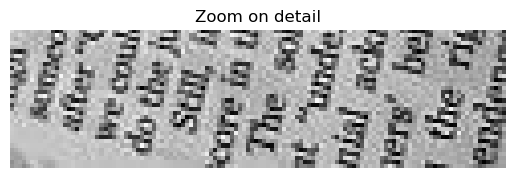

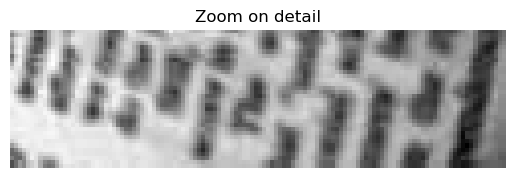

In [142]:
#Zooming on details
top_left = [200,200]
plt.imshow(fused_golf[top_left[0]:top_left[0]+200, top_left[1]:top_left[1]+200], cmap="gray")
plt.title("Zoom on detail")
plt.axis('off')
plt.show()
plt.imshow(golf2[top_left[0]:top_left[0]+200, top_left[1]:top_left[1]+200], cmap="gray")
plt.title("Zoom on detail")
plt.axis('off')
plt.show()

# Metrics

In [6]:
normalized_mutual_information_metric(rgb2gray(golf1), rgb2gray(golf2), rgb2gray(fused_golf))

0.9271456195305225

In [7]:
structural_similarity_metric(rgb2gray(golf1), rgb2gray(golf2), rgb2gray(fused_golf), 7)

0.9865127456334838

In [6]:
#Hyperparameters chosen as in the article https://www.researchgate.net/publication/3381966_Objective_image_fusion_performance_measure
#In our studied article, the authors do not specify the values of hyperparameters
gamma_g=0.9994
gamma_o=0.9879
kappa_g=-15
kappa_o=-22
sigma_g=0.5
sigma_o=0.8
L = 1.5

Q = edge_information_metric(rgb2gray(im1), rgb2gray(im2), rgb2gray(fused_image), gamma_g, gamma_o, kappa_g, kappa_o, sigma_g, sigma_o, L)
print(Q)

0.8207379221984255


# Impacts of hyperparameters

In [129]:
average_filter_size_standard=31
laplacian_kernel_size_standard=3
gaussian_filter_sigma_standard=5
gaussian_filter_radius_standard=5
local_average_size_standard=7
r1_standard=45
eps1_standard=0.3
r2_standard=7
eps2_standard=1e-6

test_img1 = plt.imread("dataset/multi-focus/color/c_03_1.tif")
test_img2 = plt.imread("dataset/multi-focus/color/c_03_2.tif")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


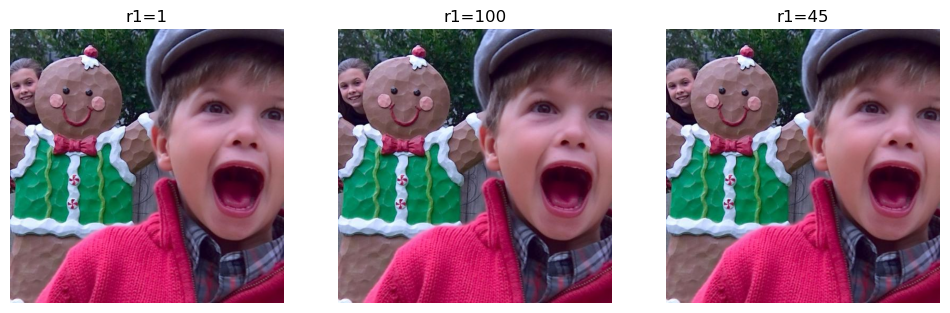

In [135]:
list_r1 = [1, 100 , r1_standard]
_, axes = plt.subplots(1, 3, figsize=(12, 5))
for i, r1 in enumerate(list_r1):
    fused_test_img = fuse_images([test_img1, test_img2], r1=r1)
    axes[i].imshow(fused_test_img)
    axes[i].axis("off")
    axes[i].set_title(f"r1={r1}")
plt.show()    

Computing base and detail layers...


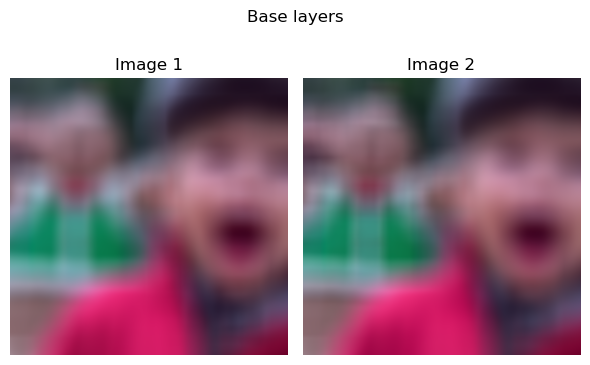

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


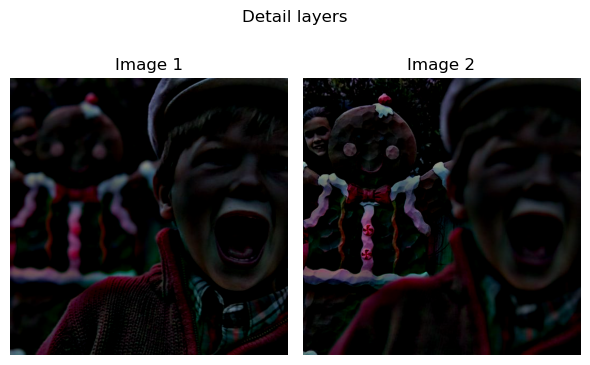


Computing saliency maps...


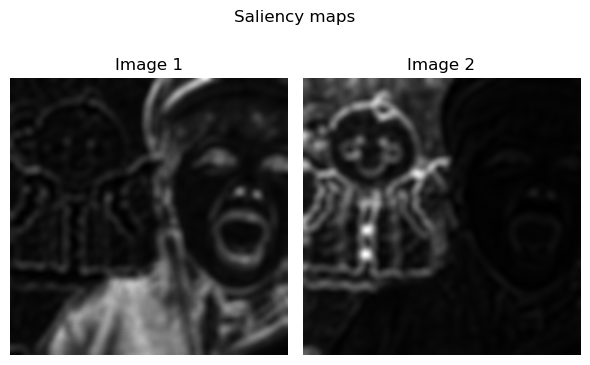


Computing weight maps...


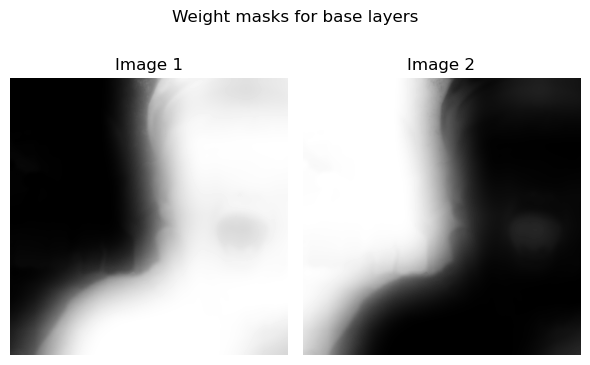

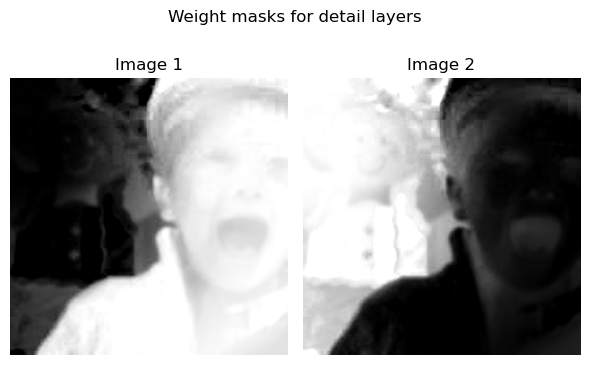

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Fusing layers...


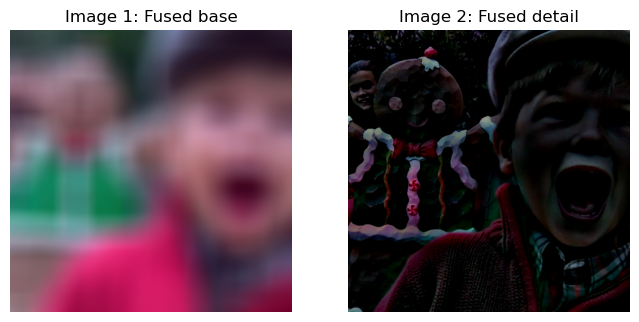

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Fused image:


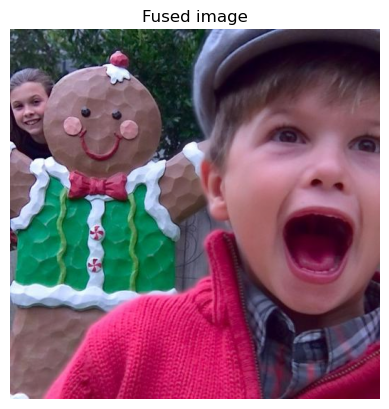

In [151]:
fused_test_img = fuse_images([test_img1, test_img2], r2=100, verbose=True)


Computing base and detail layers...


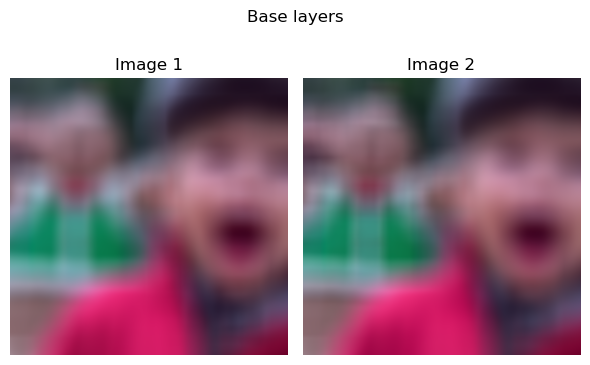

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


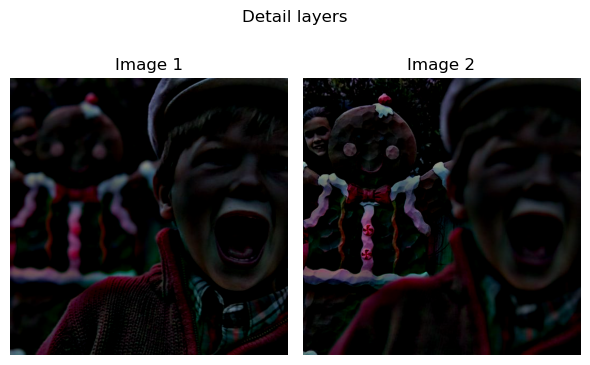


Computing saliency maps...


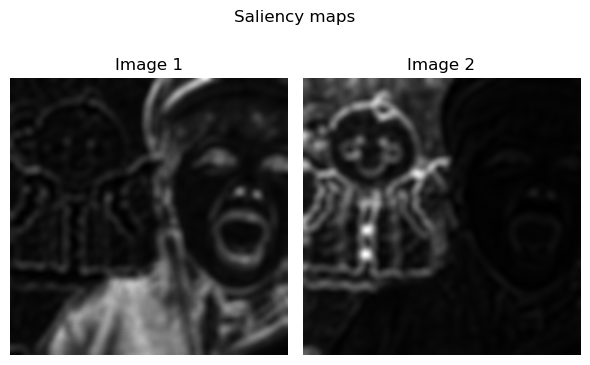


Computing weight maps...


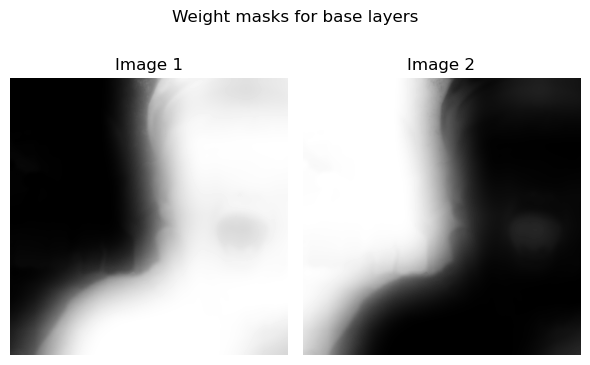

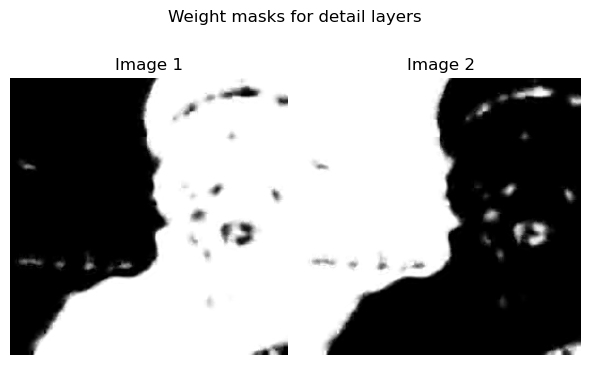

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Fusing layers...


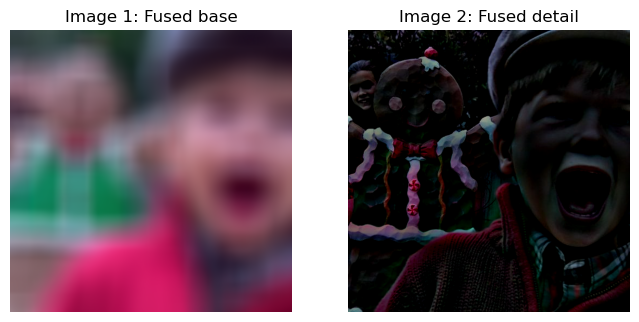

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Fused image:


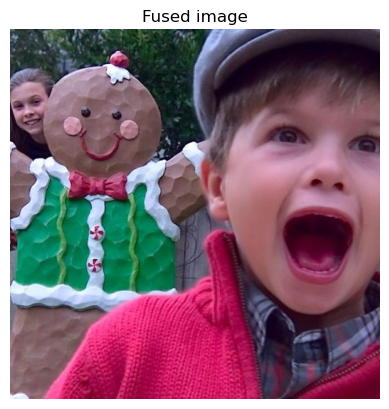

In [147]:
fused_test_img = fuse_images([test_img1, test_img2], r2=r2_standard, verbose=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


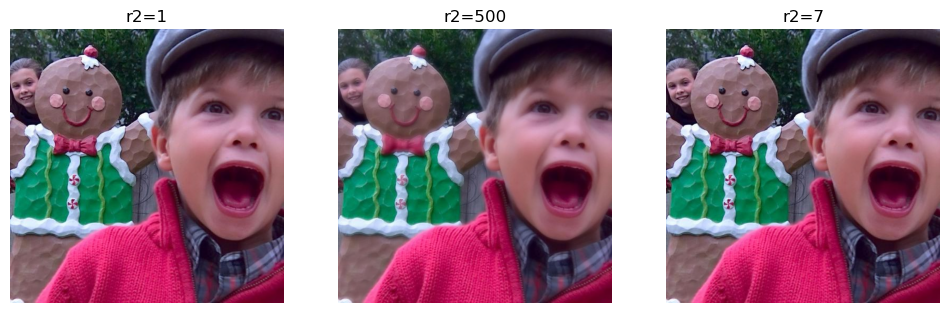

In [152]:
list_r2 = [1, 500, r2_standard]
_, axes = plt.subplots(1, 3, figsize=(12, 5))
for i, r2 in enumerate(list_r2):
    fused_test_img = fuse_images([test_img1, test_img2], r2=r2)
    axes[i].imshow(fused_test_img)
    axes[i].axis("off")
    axes[i].set_title(f"r2={r2}")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


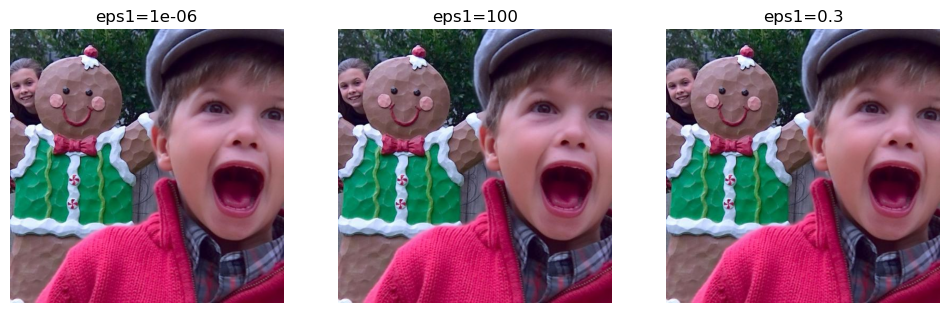

In [150]:
list_eps1 = [1e-6, 100, eps1_standard]
_, axes = plt.subplots(1, 3, figsize=(12, 5))
for i, eps1 in enumerate(list_eps1):
    fused_test_img = fuse_images([test_img1, test_img2], eps1=eps1)
    axes[i].imshow(fused_test_img)
    axes[i].axis("off")
    axes[i].set_title(f"eps1={eps1}")
plt.show()